<h4>RECOMMENDATION SYSTEM</h4>

<h4>Import necessary libraries</h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

<h4>Load dataset from kaggle: <a href=https://www.kaggle.com/datasets/dev0914sharma/dataset>https://www.kaggle.com/datasets/dev0914sharma/dataset</a></h4>

In [2]:
movies=pd.read_csv("Dataset/Movie_Id_Titles.csv")
movies.sample(5)

,item_id,title
1600,1601,Office Killer (1997)
1665,1666,Ripe (1996)
660,661,High Noon (1952)
594,595,"Fan, The (1996)"
1253,1254,Gone Fishin' (1997)


In [3]:
ratings=pd.read_csv("Dataset/Dataset.csv")
ratings.sample(5)

,user_id,item_id,rating,timestamp
41869,535,604,4,879617663
51778,474,179,5,887924424
39463,449,100,5,879958664
6815,315,302,5,879799301
18583,389,275,5,879915860


In [4]:
movies.shape

(1682, 2)

In [5]:
ratings.shape

(100003, 4)

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  1682 non-null   int64 
 1   title    1682 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [8]:
movies.duplicated().sum()

0

In [9]:
ratings.duplicated().sum()

0

<h4>Merge two datasets</h4>

In [10]:
movies_ratings=movies.merge(ratings,on='item_id')
movies_ratings

,item_id,title,user_id,rating,timestamp
0,1,Toy Story (1995),308,4,887736532
1,1,Toy Story (1995),287,5,875334088
2,1,Toy Story (1995),148,4,877019411
3,1,Toy Story (1995),280,4,891700426
4,1,Toy Story (1995),66,3,883601324
...,...,...,...,...,...
99998,1678,Mat' i syn (1997),863,1,889289570
99999,1679,B. Monkey (1998),863,3,889289491
100000,1680,Sliding Doors (1998),863,2,889289570
100001,1681,You So Crazy (1994),896,3,887160722


In [11]:
ratings['rating'].unique()

array([5, 1, 3, 2, 4], dtype=int64)

<h5>Plot of Rating Distribution</h5>

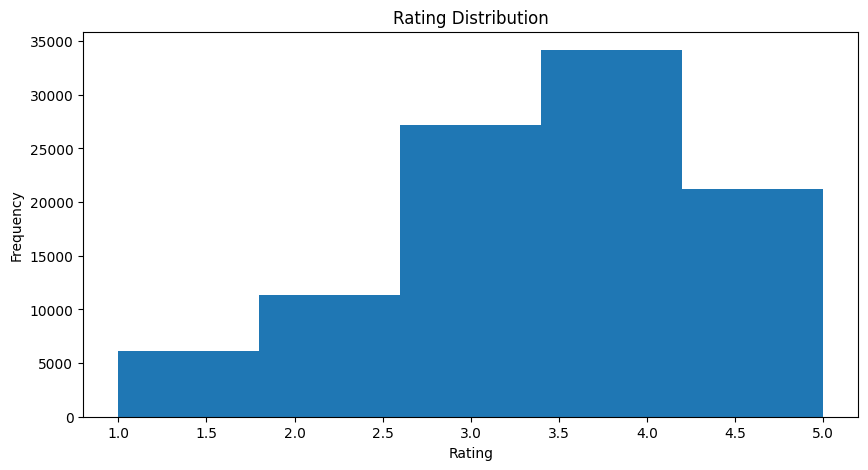

In [12]:
plt.figure(figsize=(10,5))
plt.hist(ratings['rating'],bins=5)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

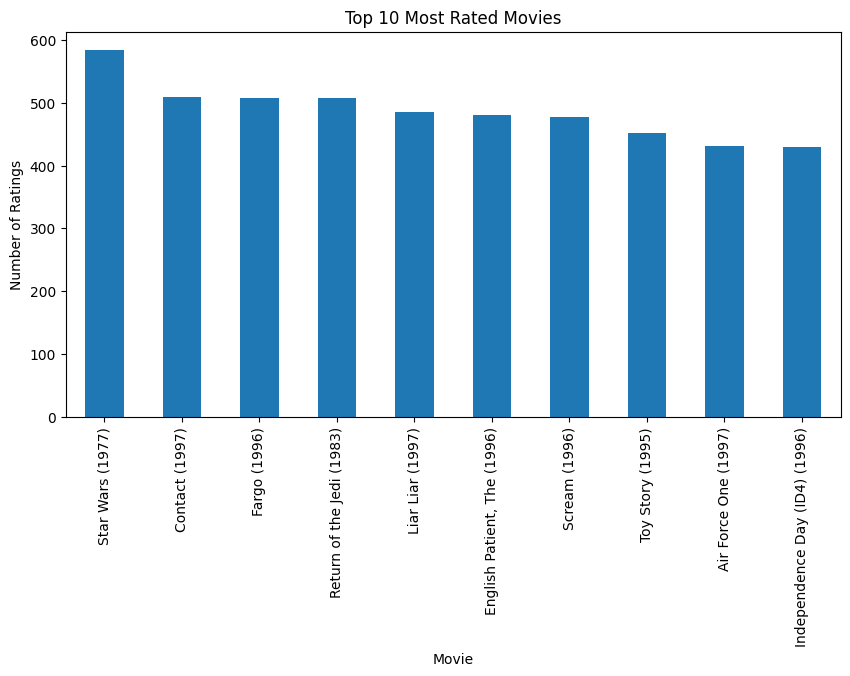

In [13]:
import matplotlib.pyplot as plt
# Top 10 most rated movies
top_movies = movies_ratings.groupby("title")["rating"].count().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_movies.plot(kind="bar")
plt.xlabel("Movie")
plt.ylabel("Number of Ratings")
plt.title("Top 10 Most Rated Movies")
plt.show()

<h4>Selecting necessary columns</h4>

In [14]:
ratings_m = movies_ratings[['user_id', 'item_id', 'rating']].copy()
ratings_m.columns = ['user_id', 'item_id', 'rating']

<h4>Preparing dataset for Surprise</h4>

In [15]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings_m[['user_id', 'item_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

<h4>Training the Model</h4>

In [16]:
# Apply SVD for matrix factorization
model = SVD()
model.fit(trainset)
predictions = model.test(testset)

<h4>Evaluation Metrics</h4>

In [17]:
# Evaluation metrics
print('--Evaluation metrics--')
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

--Evaluation metrics--
RMSE: 0.9418
MAE:  0.7424


In [18]:
from surprise.model_selection import cross_validate
cv_results=cross_validate(model,data,verbose=True)
cv_results.keys()

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9332  0.9402  0.9376  0.9424  0.9335  0.9374  0.0036  
MAE (testset)     0.7337  0.7438  0.7393  0.7412  0.7347  0.7385  0.0039  
Fit time          1.13    1.19    1.16    1.13    1.13    1.15    0.02    
Test time         0.12    0.18    0.13    0.21    0.12    0.15    0.04    


dict_keys(['test_rmse', 'test_mae', 'fit_time', 'test_time'])

In [19]:
print('Cross Validation Results')
print(f"Average RSME: {np.mean(cv_results['test_rmse']):.4f}")
print(f"Average MAE: {np.mean(cv_results['test_mae']):.4f}")


Cross Validation Results
Average RSME: 0.9374
Average MAE: 0.7385


<h4>Recommendations for sample users</h4>

In [20]:
# Recommend items for a sample user (user_id = 1)
def recommend_items(user_id, model, ratings, n=10):
    user_rated = ratings[ratings['user_id'] == user_id]['item_id'].tolist()
    all_items = set(ratings['item_id'].unique())
    unrated_items = all_items - set(user_rated)
    
    predictions = [model.predict(user_id, item) for item in unrated_items]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    print(f"Top {n} recommendations for User {user_id}:")
    for rec in recommendations:
        movie_name=movies_ratings[movies_ratings['item_id']==rec.iid]['title'].values[0]
        print(f"{movie_name} (ID:{rec.iid}) with predicted rating {rec.est:.2f}")

# Display recommendations for sample user
recommend_items(1, model, ratings)

Top 10 recommendations for User 1:
Casablanca (1942) (ID:483) with predicted rating 4.72
Lawrence of Arabia (1962) (ID:511) with predicted rating 4.58
Being There (1979) (ID:663) with predicted rating 4.53
Big Sleep, The (1946) (ID:525) with predicted rating 4.52
Some Folks Call It a Sling Blade (1993) (ID:963) with predicted rating 4.52
As Good As It Gets (1997) (ID:316) with predicted rating 4.51
Manchurian Candidate, The (1962) (ID:657) with predicted rating 4.51
Paths of Glory (1957) (ID:641) with predicted rating 4.48
African Queen, The (1951) (ID:498) with predicted rating 4.44
Rear Window (1954) (ID:603) with predicted rating 4.42


<h4>Conclusions</h4>
<h7>-The recommendation system using SVD achieved a Root Mean Square Error (RMSE) of 0.94 and Mean Absolute Error (MAE) of 0.74, indicating reliable predictions.</h7><br>
<h7>-The model successfully recommends top movies for users based on past interactions, showing predicted ratings between 3.8 and 4.5 for suggested items.</h7><br>
<h7>-Cross-validation results showed an average RMSE of 0.93 and an MAE of 0.73, demonstrating consistent performance across different data splits.</h7>